# Libraries to be used in this project.

In [46]:
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import ast
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from rake_nltk import Rake
nltk.download('vader_lexicon')

import nltk
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

import spacy

from rake_nltk import Rake

!python3 -m spacy download en_core_web_sm

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/doruktopcu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/doruktopcu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [47]:
credits_path = "datasets/tmdb5000/tmdb_5000_credits.csv"
movies_path = "datasets/tmdb5000/tmdb_5000_movies.csv"

In [48]:
movies = pd.read_csv(movies_path)
credits = pd.read_csv(credits_path)


# Data Peek

## Examples of the dataset

In [49]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [50]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [51]:
movies.describe().round(1)

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4803.0,4803.0,4803.0,4.803000e+03,4801.0,4803.0,4803.0
mean,29045039.9,57165.5,21.5,8.226064e+07,106.9,6.1,690.2
std,40722391.3,88694.6,31.8,1.628571e+08,22.6,1.2,1234.6
min,0.0,5.0,0.0,0.000000e+00,0.0,0.0,0.0
25%,790000.0,9014.5,4.7,0.000000e+00,94.0,5.6,54.0
50%,15000000.0,14629.0,12.9,1.917000e+07,103.0,6.2,235.0
75%,40000000.0,58610.5,28.3,9.291719e+07,118.0,6.8,737.0
max,380000000.0,459488.0,875.6,2.787965e+09,338.0,10.0,13752.0


In [52]:
movies.shape

(4803, 20)

In [53]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [54]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [55]:
movies.corr()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,-0.089377,0.505414,0.730823,0.269851,0.093146,0.593180
id,-0.089377,1.000000,0.031202,-0.050425,-0.153536,-0.270595,-0.004128
popularity,0.505414,0.031202,1.000000,0.644724,0.225502,0.273952,0.778130
revenue,0.730823,-0.050425,0.644724,1.000000,0.251093,0.197150,0.781487
runtime,0.269851,-0.153536,0.225502,0.251093,1.000000,0.375046,0.271944
vote_average,0.093146,-0.270595,0.273952,0.197150,0.375046,1.000000,0.312997
vote_count,0.593180,-0.004128,0.778130,0.781487,0.271944,0.312997,1.000000


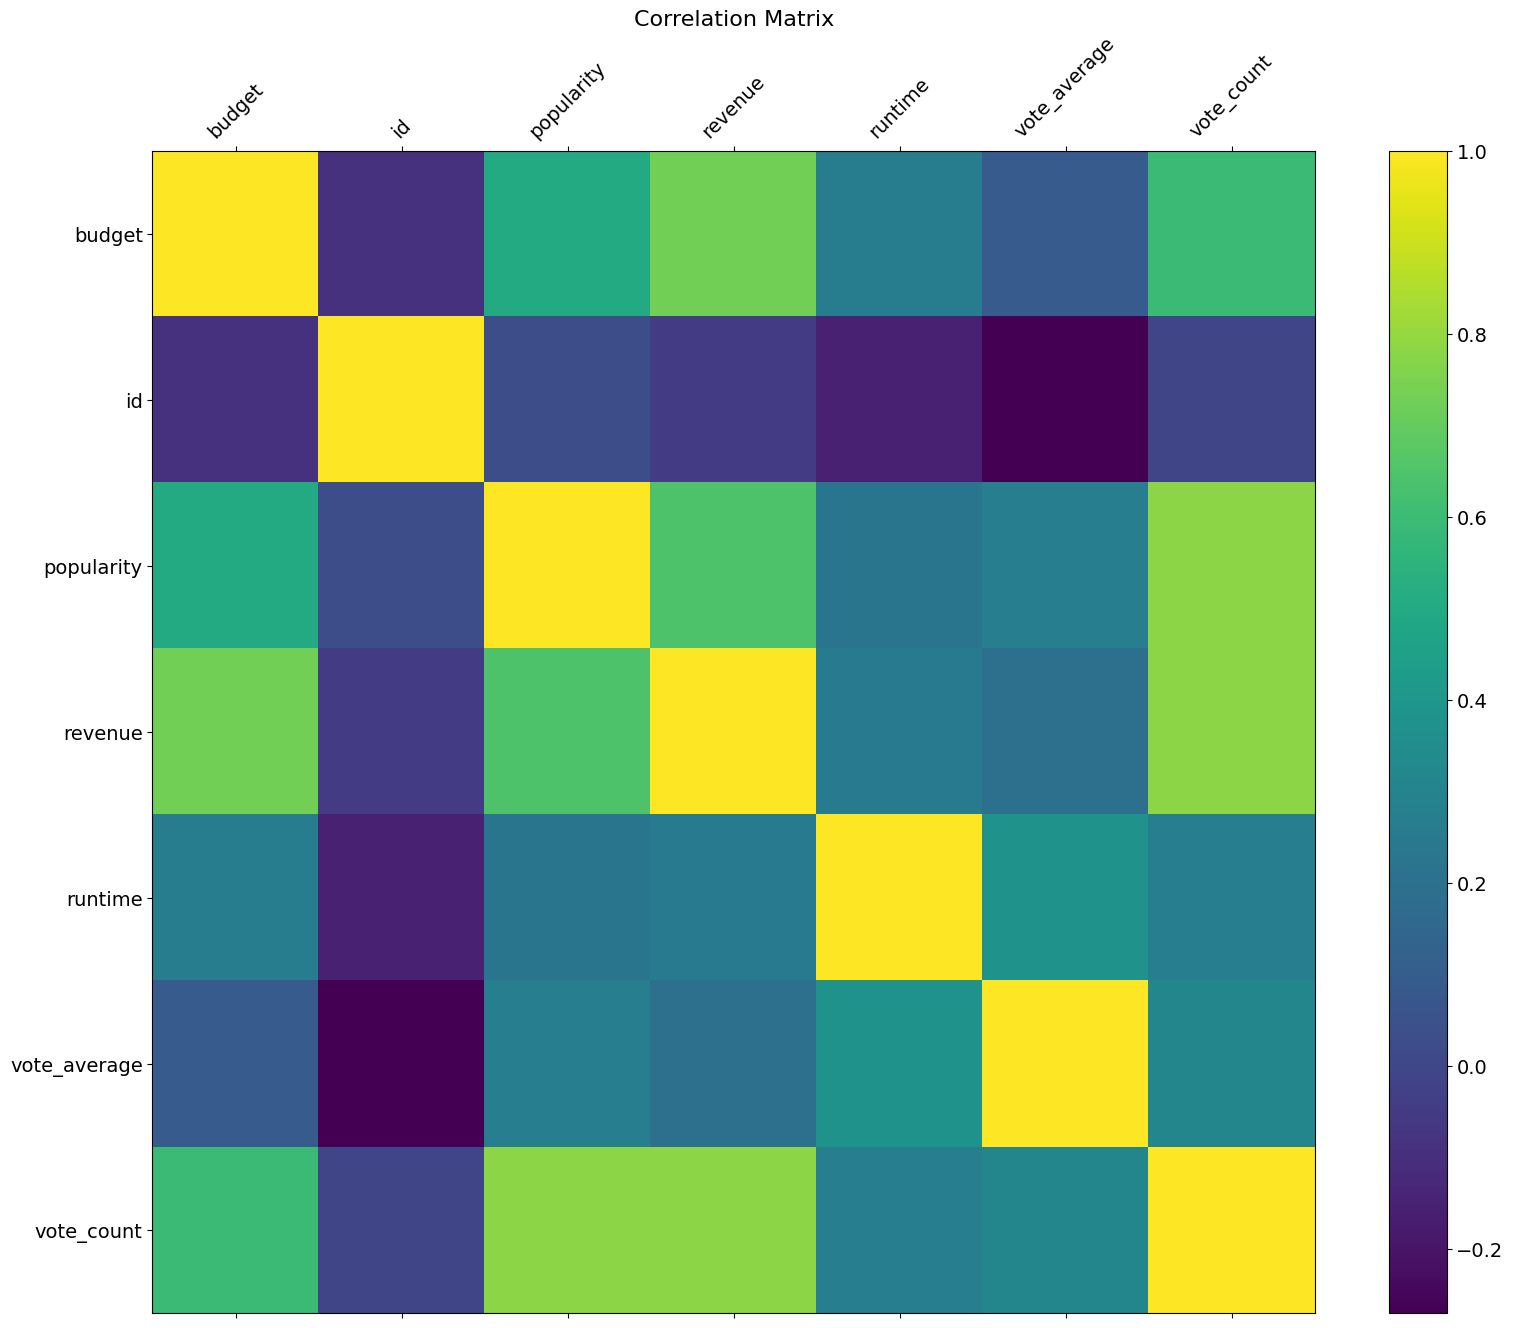

In [56]:
f = plt.figure(figsize=(19, 15))
plt.matshow(movies.corr(), fignum=f.number)
plt.xticks(range(movies.select_dtypes(['number']).shape[1]), movies.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(movies.select_dtypes(['number']).shape[1]), movies.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### We will remove some of these features and do some preprocessing on keywords and other features since it is not going to contribute in recommending the movie or we will need them in different forms.

In [57]:
movies_clean_path = "datasets/tmdb-clean/tmdb_5000_movies_clean.csv"
movies_clean = pd.read_csv(movies_clean_path)

In [58]:
movies_clean.corr()

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.505414,0.730823,0.269851,0.093146,0.593180
popularity,0.505414,1.000000,0.644724,0.225502,0.273952,0.778130
revenue,0.730823,0.644724,1.000000,0.251093,0.197150,0.781487
runtime,0.269851,0.225502,0.251093,1.000000,0.375046,0.271944
vote_average,0.093146,0.273952,0.197150,0.375046,1.000000,0.312997
vote_count,0.593180,0.778130,0.781487,0.271944,0.312997,1.000000


In [59]:
movies_clean.head(2)

,title,budget,genres,keywords,original_language,overview,popularity,production_companies,revenue,runtime,tagline,vote_average,vote_count
0,Avatar,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2787965087,162.0,Enter the World of Pandora.,7.2,11800
1,Pirates of the Caribbean: At World's End,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500


In [60]:
# Duplicate Data check
movies_clean.duplicated().sum()

0

In [61]:
movies_clean.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


Change from json to list of keywords and genres.

In [62]:
def converter(obj):
    genreList = []
    for i in ast.literal_eval(obj):
        genreList.append(i['name'])
    return genreList

movies_clean['genres'] = movies_clean['genres'].apply(converter)
movies_clean['keywords'] = movies['keywords'].apply(converter)
movies_clean['production_companies'] = movies['production_companies'].apply(converter)

In [63]:
movies_clean.head(2)

,title,budget,genres,keywords,original_language,overview,popularity,production_companies,revenue,runtime,tagline,vote_average,vote_count
0,Avatar,237000000,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",2787965087,162.0,Enter the World of Pandora.,7.2,11800
1,Pirates of the Caribbean: At World's End,300000000,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500


In [64]:
movies_clean['overview']

0       In the 22nd century, a paraplegic Marine is di...
1       Captain Barbossa, long believed to be dead, ha...
2       A cryptic message from Bond’s past sends him o...
3       Following the death of District Attorney Harve...
4       John Carter is a war-weary, former military ca...
                              ...                        
4798    El Mariachi just wants to play his guitar and ...
4799    A newlywed couple's honeymoon is upended by th...
4800    "Signed, Sealed, Delivered" introduces a dedic...
4801    When ambitious New York attorney Sam is sent t...
4802    Ever since the second grade when he first saw ...
Name: overview, Length: 4803, dtype: object

In [65]:
movies_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 4803 non-null   object 
 1   budget                4803 non-null   int64  
 2   genres                4803 non-null   object 
 3   keywords              4803 non-null   object 
 4   original_language     4803 non-null   object 
 5   overview              4800 non-null   object 
 6   popularity            4803 non-null   float64
 7   production_companies  4803 non-null   object 
 8   revenue               4803 non-null   int64  
 9   runtime               4801 non-null   float64
 10  tagline               3959 non-null   object 
 11  vote_average          4803 non-null   float64
 12  vote_count            4803 non-null   int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 487.9+ KB


In [66]:
movies_clean['general_overview'] =movies_clean['overview'].astype(str) + movies_clean['keywords'].astype(str) + movies_clean['genres'].astype(str) + movies_clean['title'].astype(str)

In [67]:
movies_clean.head(2)

,title,budget,genres,keywords,original_language,overview,popularity,production_companies,revenue,runtime,tagline,vote_average,vote_count,general_overview
0,Avatar,237000000,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",2787965087,162.0,Enter the World of Pandora.,7.2,11800,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,300000000,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500,"Captain Barbossa, long believed to be dead, ha..."


In [68]:
movies_clean = movies_clean.drop('genres', axis=1)
movies_clean = movies_clean.drop('keywords', axis=1)
movies_clean = movies_clean.drop('overview', axis=1)

In [69]:
movies_clean.head(2)

,title,budget,original_language,popularity,production_companies,revenue,runtime,tagline,vote_average,vote_count,general_overview
0,Avatar,237000000,en,150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",2787965087,162.0,Enter the World of Pandora.,7.2,11800,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,300000000,en,139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500,"Captain Barbossa, long believed to be dead, ha..."


In [70]:
movies_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 4803 non-null   object 
 1   budget                4803 non-null   int64  
 2   original_language     4803 non-null   object 
 3   popularity            4803 non-null   float64
 4   production_companies  4803 non-null   object 
 5   revenue               4803 non-null   int64  
 6   runtime               4801 non-null   float64
 7   tagline               3959 non-null   object 
 8   vote_average          4803 non-null   float64
 9   vote_count            4803 non-null   int64  
 10  general_overview      4803 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 412.9+ KB


In [71]:
movies_clean['general_overview'] = movies_clean['general_overview'].astype(str) + movies_clean['tagline'].astype(str)

In [72]:
movies_clean['general_overview'] = movies_clean['general_overview'].astype(str) + movies_clean['production_companies'].astype(str)
movies_clean = movies_clean.drop('production_companies', axis=1)


In [73]:
movies_clean = movies_clean.drop('tagline', axis=1)

In [74]:
movies_clean.head(2)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview
0,Avatar,237000000,en,150.437577,2787965087,162.0,7.2,11800,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,300000000,en,139.082615,961000000,169.0,6.9,4500,"Captain Barbossa, long believed to be dead, ha..."


In [75]:

text = "This is an example text with stopwords and symbols!@#"

def stopword_punct_remover_nltk(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and symbols from the list of tokens
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords.words('english') and token not in string.punctuation]

    # Join the filtered tokens to form a new text
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

In [76]:
# movies_clean['general_overview'] = movies_clean['general_overview'].apply(stopword_punct_remover_nltk)

In [77]:
movies_clean['general_overview'][0]

"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.['culture clash', 'future', 'space war', 'space colony', 'society', 'space travel', 'futuristic', 'romance', 'space', 'alien', 'tribe', 'alien planet', 'cgi', 'marine', 'soldier', 'battle', 'love affair', 'anti war', 'power relations', 'mind and soul', '3d']['Action', 'Adventure', 'Fantasy', 'Science Fiction']AvatarEnter the World of Pandora.['Ingenious Film Partners', 'Twentieth Century Fox Film Corporation', 'Dune Entertainment', 'Lightstorm Entertainment']"

In [78]:
movies_clean.columns

Index(['title', 'budget', 'original_language', 'popularity', 'revenue',
       'runtime', 'vote_average', 'vote_count', 'general_overview'],
      dtype='object')

In [79]:
movies_clean.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [80]:
movies_clean.columns

Index(['title', 'budget', 'original_language', 'popularity', 'revenue',
       'runtime', 'vote_average', 'vote_count', 'general_overview'],
      dtype='object')

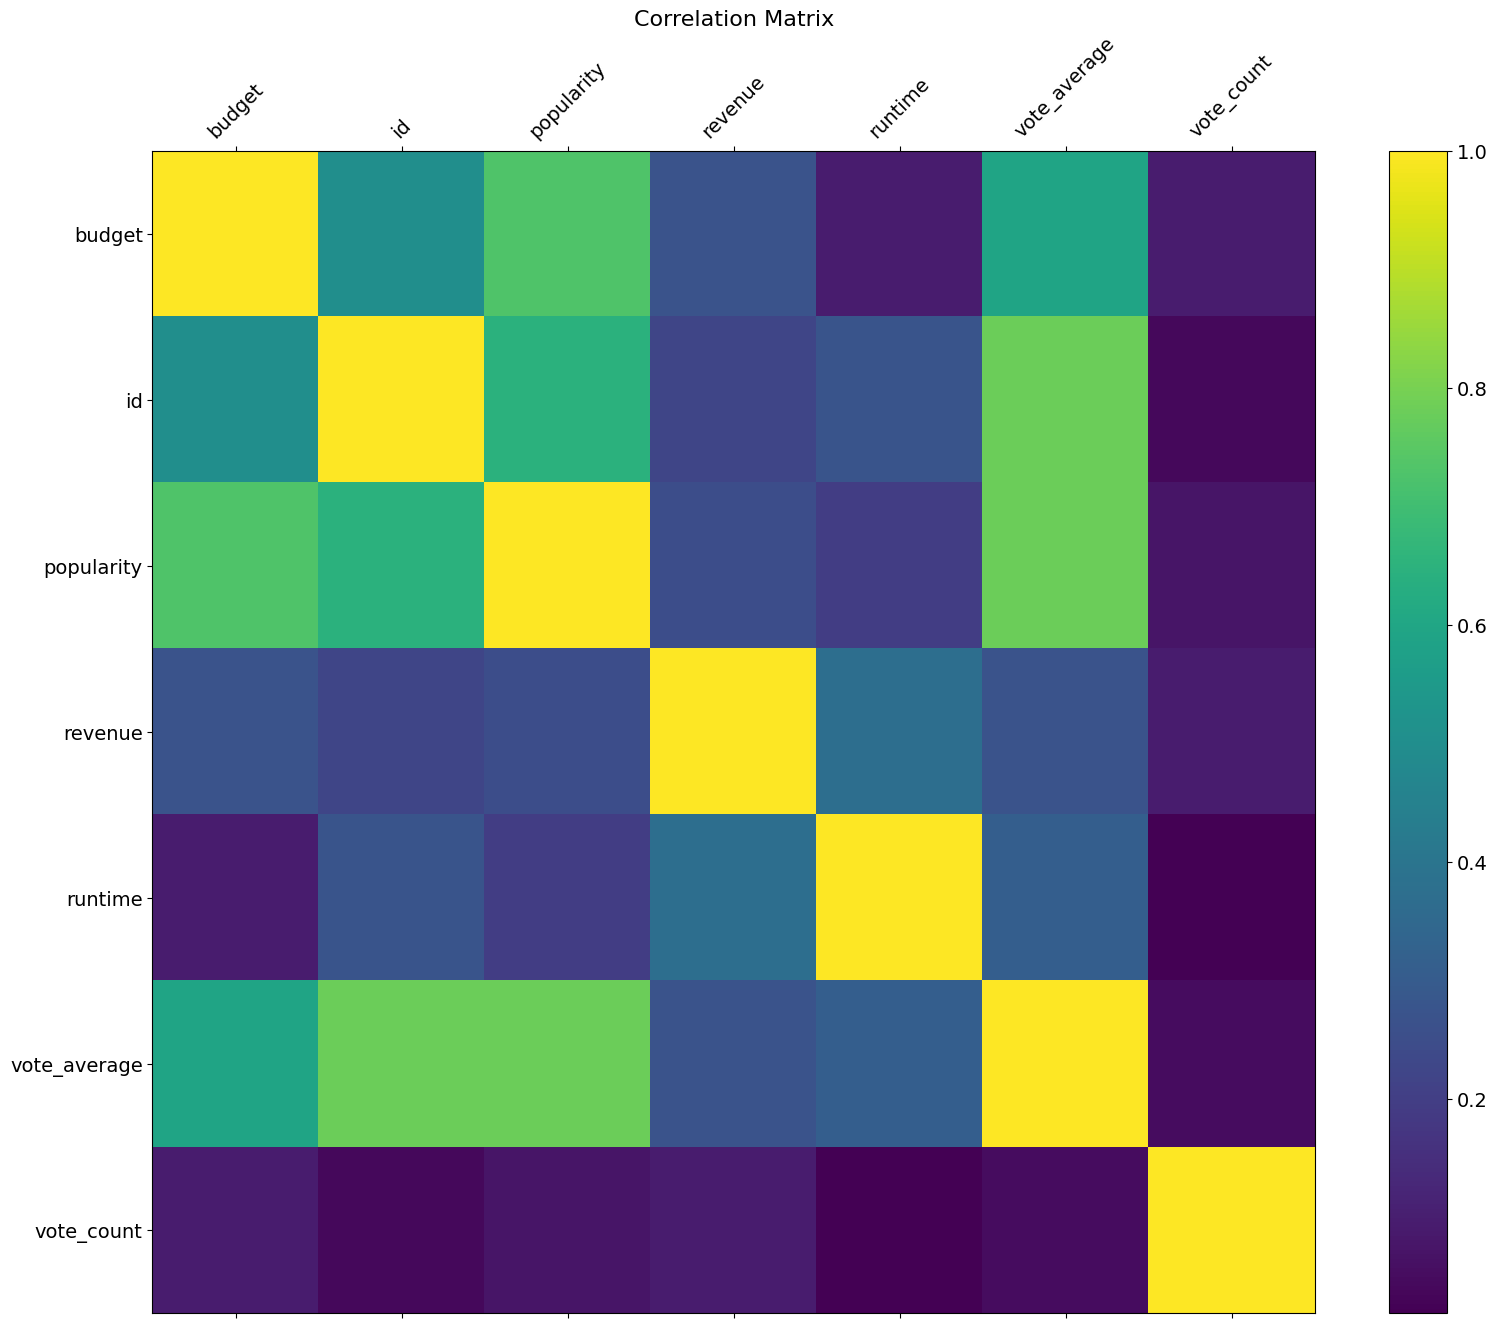

In [102]:
f = plt.figure(figsize=(19, 15))
plt.matshow(movies_clean.corr(), fignum=f.number)
plt.xticks(range(movies_clean.select_dtypes(['number']).shape[1]), movies.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(movies_clean.select_dtypes(['number']).shape[1]), movies.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# How to recommend?

## Define the recommender function based on the demand.

In [81]:
def general_recommender(df, 
budget=300000, 
language='en', 
popularity=31, 
revenue= 800000, 
runtime= 106, 
min_vote_avg = 6, 
max_vote_avg = 10, 
vote_count = 300):

    df_filtered = df[(df['budget'] >= budget) &  (df['original_language'] == language) & (df['popularity'] >= popularity) & (df['revenue'] >= revenue) & (df['runtime'] >= runtime) & (df['vote_average'] >= min_vote_avg) & (df['vote_count'] >= vote_count) & (df['vote_average'] <= max_vote_avg)]
    return df_filtered

In [82]:
df_movie_recommended = general_recommender(movies_clean, popularity=50, runtime=130, min_vote_avg= 6, max_vote_avg=7)

In [83]:
df_movie_recommended.head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview
1,Pirates of the Caribbean: At World's End,300000000,en,139.082615,961000000,169.0,6.9,4500,"Captain Barbossa, long believed to be dead, ha..."
2,Spectre,245000000,en,107.376788,880674609,148.0,6.3,4466,A cryptic message from Bond’s past sends him o...
12,Pirates of the Caribbean: Dead Man's Chest,200000000,en,145.847379,1065659812,151.0,7.0,5246,Captain Jack Sparrow works his way out of a bl...
14,Man of Steel,225000000,en,99.398009,662845518,143.0,6.5,6359,A young boy learns that he has extraordinary p...
15,The Chronicles of Narnia: Prince Caspian,225000000,en,53.978602,419651413,150.0,6.3,1630,One year after their incredible adventures in ...
17,Pirates of the Caribbean: On Stranger Tides,380000000,en,135.413856,1045713802,136.0,6.4,4948,Captain Jack Sparrow crosses paths with a woma...
20,The Amazing Spider-Man,215000000,en,89.866276,752215857,136.0,6.5,6586,Peter Parker is an outcast high schooler aband...
24,King Kong,207000000,en,61.226010,550000000,187.0,6.6,2337,"In 1933 New York, an overly ambitious movie pr..."
29,Skyfall,200000000,en,93.004993,1108561013,143.0,6.9,7604,When Bond's latest assignment goes gravely wro...
31,Iron Man 3,200000000,en,77.682080,1215439994,130.0,6.8,8806,When Tony Stark's world is torn apart by a for...


### User input is taken as text.
### Similarities between user input and overview is compared.
### Most matched 10 movies are found recommended to user.

In [84]:
def user_input_recommender(df, 
user_input="", 
budget=100, 
popularity=15, 
revenue= 80000, 
runtime= 20,
min_vote_avg = 4,
vote_count = 100):


    # Create an instance of the CountVectorizer
    vectorizer = CountVectorizer()

    # Fit and transform the dataframe column and user input
    texts = df['general_overview'].tolist()
    texts.append(user_input)
    vectors = vectorizer.fit_transform(texts).toarray()

    # Calculate the cosine similarity between user input and each row in the dataframe
    similarities = cosine_similarity(vectors)[-1][:-1]

    df["similarity"] = similarities

    # Filter the dataframe based on the similarity score
    df_filtered = df[(df['budget'] >= budget) &  
    (df['popularity'] >= popularity) & 
    (df['revenue'] >= revenue) & 
    (df['runtime'] >= runtime) & 
    (df['vote_average'] >= min_vote_avg) & 
    (df['vote_count'] >= vote_count)]

    df_sorted = df_filtered.sort_values(by='similarity', ascending = False)


    return df_sorted

In [85]:
user_input_recommender(movies_clean, user_input="Cartoon Comedy", min_vote_avg=6.2).head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
2018,There's Something About Mary,23000000,en,57.110486,369884651,119.0,6.5,1590,Having never fully recovered from a prom date ...,0.293294
452,Space Jam,80000000,en,36.125715,250200000,88.0,6.5,1288,In a desperate attempt to win a basketball mat...,0.249029
3883,Animal House,2700000,en,17.332585,141000000,109.0,7.0,418,"At a 1962 College, Dean Vernon Wormer is deter...",0.218797
1940,Carnage,25000000,en,20.011435,27603069,80.0,7.0,738,After 11-year-old Zachary Cowan strikes his cl...,0.206041
3824,The Full Monty,3500000,en,17.002623,257850122,91.0,6.8,363,"Sheffield, England. Gaz, a jobless steelworker...",0.190693
3597,Shaun of the Dead,4000000,en,49.124860,30039392,99.0,7.5,2420,"Shaun lives a supremely uneventful life, which...",0.178647
1695,Aladdin,28000000,en,92.982009,504050219,90.0,7.4,3416,Princess Jasmine grows tired of being forced t...,0.168763
3245,50/50,8000000,en,33.372828,39187783,100.0,7.0,1261,"Inspired by a true story, a comedy centered on...",0.163299
1579,Midnight in Paris,30000000,en,43.753585,151119219,94.0,7.4,1990,A romantic comedy about a family traveling to ...,0.161165
3334,Juno,7500000,en,19.782725,231411584,96.0,7.0,2244,A young girl named Juno gets herself pregnant ...,0.157135


In [86]:
user_input_recommender(movies_clean, user_input="Virus outbreak pandemic", min_vote_avg=6.2).head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
720,Contagion,60000000,en,38.820858,137551594,106.0,6.2,1325,As an epidemic of a lethal airborne virus - th...,0.235702
3240,28 Days Later,5000000,en,45.490374,82719885,113.0,7.1,1777,Twenty-eight days after a killer virus was acc...,0.158114
1395,Resident Evil,33000000,en,40.715623,102984862,100.0,6.4,2065,"When a virus leaks from a top-secret facility,...",0.154303
929,Outbreak,50000000,en,30.397496,189859560,127.0,6.3,513,A deadly airborne virus finds its way into the...,0.146911
116,I Am Legend,150000000,en,70.867401,585349010,101.0,6.9,4853,Robert Neville is a scientist who was unable t...,0.123091
1281,Hackers,20000000,en,17.842246,7563728,107.0,6.2,398,"Along with his new friends, a teenager who was...",0.122782
2293,The Crazies,20000000,en,28.867568,54956140,101.0,6.2,633,Four friends find themselves trapped in their ...,0.079305
2561,28 Weeks Later,15000000,en,34.759855,64238440,100.0,6.5,1197,"In this chilling sequel to 28 Days Later, the ...",0.063953
695,GoldenEye,58000000,en,59.824565,352194034,130.0,6.6,1174,James Bond must unmask the mysterious head of ...,0.061546
446,Con Air,75000000,en,45.154631,224012234,115.0,6.5,1270,When the government puts all its rotten crimin...,0.045644


In [87]:
user_input_recommender(movies_clean, user_input="Love hate and action").head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
164,Lethal Weapon 4,140000000,en,24.855701,285444603,127.0,6.3,767,In the combustible action franchise's final in...,0.396203
1408,Closer,27000000,en,22.636908,115505027,104.0,6.7,811,"A witty, romantic, and very dangerous love sto...",0.357771
617,Agora,70000000,en,18.888806,39041505,127.0,6.9,395,"A historical drama set in Roman Egypt, concern...",0.340207
1997,Her,23000000,en,53.682367,47351251,126.0,7.9,4097,"In the not so distant future, Theodore, a lone...",0.336861
3743,Leaving Las Vegas,3600000,en,22.030517,49800000,112.0,7.1,360,"Ben Sanderson, an alcoholic Hollywood screenwr...",0.333712
2661,Romeo + Juliet,14500000,en,41.493042,147298761,120.0,6.7,1374,In director Baz Luhrmann's contemporary take o...,0.326599
3695,The Blue Lagoon,4500000,en,22.585384,58853106,104.0,5.8,408,Two small children and a ship's cook survive a...,0.317221
1745,My Sister's Keeper,30000000,en,24.091520,95714875,109.0,7.1,598,Sara and Brian live an idyllic life with their...,0.300421
2134,This Is Where I Leave You,19800000,en,20.311684,41296320,103.0,6.5,505,"When their father passes away, four grown, wor...",0.298142
2836,Frida,12000000,en,18.422327,56298474,123.0,7.3,383,"""Frida"" chronicles the life Frida Kahlo shared...",0.295689


In [88]:
user_input_recommender(movies_clean, min_vote_avg = 6,
user_input="A scray thriller with killers and victims."
).head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
2836,Frida,12000000,en,18.422327,56298474,123.0,7.3,383,"""Frida"" chronicles the life Frida Kahlo shared...",0.331964
2134,This Is Where I Leave You,19800000,en,20.311684,41296320,103.0,6.5,505,"When their father passes away, four grown, wor...",0.273861
164,Lethal Weapon 4,140000000,en,24.855701,285444603,127.0,6.3,767,In the combustible action franchise's final in...,0.251610
3556,10 Cloverfield Lane,15000000,en,53.698683,108286421,103.0,6.8,2468,"After a car accident, Michelle awakens to find...",0.250581
1196,The Prestige,40000000,en,74.440708,109676311,130.0,8.0,4391,A mysterious story of two magicians whose inte...,0.247537
2883,Stoker,12000000,en,27.322212,12077441,99.0,6.5,882,"After India's father dies, her Uncle Charlie, ...",0.247537
3524,[REC]²,5600000,es,22.341462,18469680,85.0,6.4,489,"The action continues from [REC], with the medi...",0.243975
1909,Legend,25000000,en,32.854557,42972994,131.0,6.7,973,"Suave, charming and volatile, Reggie Kray and ...",0.241523
2688,A Perfect Getaway,14000000,en,20.792603,22852638,98.0,6.2,351,"For their honeymoon, newlyweds Cliff and Cydne...",0.240707
919,Payback,90000000,en,17.457947,161626121,100.0,6.7,548,"With friends like these, who needs enemies? Th...",0.239046


In [101]:
user_input_recommender(movies_clean, user_input="The Matrix").head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
2986,The Longest Day,10000000,en,19.524972,50100000,178.0,7.2,234,"The retelling of June 6, 1944, from the perspe...",0.558661
229,Star Wars: Episode III - Revenge of the Sith,113000000,en,44.108427,850000000,140.0,7.1,4116,"Years after the onset of the Clone Wars, the n...",0.542451
125,The Matrix Reloaded,150000000,en,70.785910,738599701,138.0,6.7,3443,Six months after the events depicted in The Ma...,0.542326
634,The Matrix,63000000,en,104.309993,463517383,136.0,7.9,8907,"Set in the 22nd century, The Matrix tells the ...",0.539784
1759,The Right Stuff,27000000,en,17.567332,21500000,193.0,7.3,235,A chronicle of the original Mercury astronauts...,0.537733
2308,Land of the Dead,15000000,en,15.262492,46770602,93.0,6.0,381,The world is full of zombies and the survivors...,0.536745
549,Sphere,75000000,en,18.659880,13100000,134.0,5.8,476,The OSSA discovers a spacecraft thought to be ...,0.528089
329,The Lord of the Rings: The Return of the King,94000000,en,123.630332,1118888979,201.0,8.1,8064,Aragorn is revealed as the heir to the ancient...,0.514496
2503,The Homesman,16000000,en,20.591480,3442853,122.0,6.4,258,When three women living on the edge of the Ame...,0.509175
2396,Hoodwinked!,15000000,en,23.980329,51053787,80.0,5.9,479,The recipes of candies of the goody shops have...,0.508475


In [90]:
user_input_recommender(movies_clean, user_input="I want to watch a movie about two strangers, action and romance", min_vote_avg=7).head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
2572,Boogie Nights,15000000,en,19.855790,43101594,155.0,7.5,796,"Set in 1977, back when sex was safe, pleasure ...",0.270837
1048,The Bucket List,45000000,en,31.305336,175372502,97.0,7.0,1111,Corporate billionaire Edward Cole and working ...,0.260423
2836,Frida,12000000,en,18.422327,56298474,123.0,7.3,383,"""Frida"" chronicles the life Frida Kahlo shared...",0.257139
3622,Once Upon a Time in the West,5000000,it,49.333137,5321508,175.0,8.1,1128,This classic western masterpiece is an epic fi...,0.251040
3334,Juno,7500000,en,19.782725,231411584,96.0,7.0,2244,A young girl named Juno gets herself pregnant ...,0.245955
2449,Sense and Sensibility,16500000,en,20.898711,135000000,136.0,7.2,352,"Rich Mr. Dashwood dies, leaving his second wif...",0.245955
1177,Sin City,40000000,en,66.003433,158733820,124.0,7.2,2691,Welcome to Sin City. This town beckons to the ...,0.245239
2935,Brooklyn,11000000,en,39.337949,62076141,111.0,7.2,1213,"In 1950s Ireland and New York, young Ellis Lac...",0.244451
274,Gladiator,103000000,en,95.301296,457640427,155.0,7.9,5439,"In the year 180, the death of emperor Marcus A...",0.241046
2285,Back to the Future,19000000,en,76.603233,381109762,116.0,8.0,6079,Eighties teenager Marty McFly is accidentally ...,0.240481


In [91]:
user_input_recommender(movies_clean, user_input="disaster, chaos, cyber attack", min_vote_avg=5).head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
606,Blackhat,70000000,en,46.832372,17752940,133.0,5.1,826,A man is released from prison to help American...,0.170872
4738,Pi,60000,en,27.788067,3221152,84.0,7.1,586,The debut film from Darren Aronofsky in which ...,0.111803
941,13 Hours: The Secret Soldiers of Benghazi,50000000,en,42.526529,69411370,144.0,7.0,938,An American Ambassador is killed during an att...,0.097129
1484,Snakes on a Plane,33000000,en,19.642328,62022014,105.0,5.1,497,America is on the search for the murderer Eddi...,0.095346
28,Jurassic World,150000000,en,418.708552,1513528810,124.0,6.5,8662,Twenty-two years after the events of Jurassic ...,0.092848
580,Olympus Has Fallen,70000000,en,59.428223,161025640,120.0,6.2,2981,"When the White House (Secret Service Code: ""Ol...",0.080845
1826,Cloverfield,25000000,en,46.942396,170764026,85.0,6.4,2251,Five young New Yorkers throw their friend a go...,0.080064
383,Twister,92000000,en,32.079995,494471524,113.0,6.1,950,TV weatherman Bill Harding is trying to get hi...,0.079556
582,Battle: Los Angeles,70000000,en,49.199234,202466756,116.0,5.5,1448,The Earth is attacked by unknown forces. As pe...,0.077850
243,Night at the Museum,110000000,en,48.780039,574480841,108.0,6.3,2862,Chaos reigns at the natural history museum whe...,0.075593


### First you should run "pip install spacy" then "python -m spacy download en_core_web_sm" in terminal.

In [92]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

# Define the sentence
sentence = "This is an example sentence with keywords"

# Process the sentence with spacy
doc = nlp(sentence)

# Extract the keywords
keywords = [token.text for token in doc if not token.is_stop and not token.is_punct]

# Print the keywords
print(keywords)

['example', 'sentence', 'keywords']


In [93]:
def user_input_recommender_keywords(df, 
user_input="", 
budget=100, 
popularity=15, 
revenue= 80000, 
runtime= 20,
min_vote_avg = 4,
vote_count = 100):

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(user_input)
    keywords = [token.text for token in doc if not token.is_stop and not token.is_punct]
    for keyword in keywords:
        user_input += (" "+ keyword)
    # Create an instance of the CountVectorizer
    vectorizer = CountVectorizer()

    # Fit and transform the dataframe column and user input
    texts = df['general_overview'].tolist()
    texts.append(user_input)
    vectors = vectorizer.fit_transform(texts).toarray()


    # Calculate the cosine similarity between user input and each row in the dataframe
    similarities = cosine_similarity(vectors)[-1][:-1]

    df["similarity"] = similarities

    # Filter the dataframe based on the similarity score
    df_filtered = df[(df['budget'] >= budget) &  
    (df['popularity'] >= popularity) & 
    (df['revenue'] >= revenue) & 
    (df['runtime'] >= runtime) & 
    (df['vote_average'] >= min_vote_avg) & 
    (df['vote_count'] >= vote_count)]

    df_sorted = df_filtered.sort_values(by='similarity', ascending = False)


    return df_sorted[['title', 'vote_average', 'similarity']]

In [94]:
user_input_recommender_keywords(movies_clean, user_input="I want to watch something about techology, sci-fi, pandemic, crazy romance", min_vote_avg=6, budget=10000000).head(10)

,title,vote_average,similarity
2172,Endless Love,6.7,0.160357
1053,Galaxy Quest,6.9,0.148250
295,The Tourist,6.0,0.131912
1540,American Pie 2,6.0,0.129862
616,Ted 2,6.2,0.124035
2018,There's Something About Mary,6.5,0.122694
1567,Warm Bodies,6.4,0.119523
1031,My Best Friend's Wedding,6.3,0.114386
1887,A Lot Like Love,6.5,0.112687
2790,True Romance,7.5,0.111998


In [95]:
user_input_recommender_keywords(movies_clean, user_input="Fast and furious cars street race").head(10)

,title,vote_average,similarity
40,Cars 2,5.8,0.207020
44,Furious 7,7.3,0.203653
629,Need for Speed,6.1,0.197949
3697,Fast Times at Ridgemont High,7.0,0.194377
1186,The Final Destination,5.4,0.168687
1404,Street Fighter,4.1,0.152204
3893,A Nightmare on Elm Street Part 2: Freddy's Rev...,5.7,0.144479
3420,Boyz n the Hood,7.4,0.144338
658,Death Race,6.0,0.143499
298,The Wolf of Wall Street,7.9,0.142014


In [96]:
user_input_recommender_keywords(movies_clean, user_input="Funny show about life amd death", min_vote_avg=5).head(10)

,title,vote_average,similarity
1786,Flatliners,6.3,0.282843
1993,Final Destination,6.4,0.217732
1839,Final Destination 3,5.8,0.201008
980,The Life of David Gale,7.3,0.197666
3596,Y Tu Mamá También,7.3,0.195217
66,Up,7.7,0.184900
978,The Life Aquatic with Steve Zissou,7.1,0.178647
1588,P.S. I Love You,6.9,0.170251
2926,Dead Man Walking,7.3,0.168232
1316,Precious,6.9,0.167506


In [97]:
user_input_recommender(movies_clean, user_input="Funny show about life and death", min_vote_avg=5).head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
1786,Flatliners,26000000,en,24.114459,61489265,115.0,6.3,404,Five medical students want to find out if ther...,0.326599
2836,Frida,12000000,en,18.422327,56298474,123.0,7.3,383,"""Frida"" chronicles the life Frida Kahlo shared...",0.301786
66,Up,175000000,en,92.201962,735099082,96.0,7.7,6870,Carl Fredricksen spent his entire life dreamin...,0.280224
891,Man on the Moon,82000000,en,24.444186,47434430,118.0,6.9,435,A film about the life and career of the eccent...,0.275241
2134,This Is Where I Leave You,19800000,en,20.311684,41296320,103.0,6.5,505,"When their father passes away, four grown, wor...",0.273861
1745,My Sister's Keeper,30000000,en,24.091520,95714875,109.0,7.1,598,Sara and Brian live an idyllic life with their...,0.269822
3622,Once Upon a Time in the West,5000000,it,49.333137,5321508,175.0,8.1,1128,This classic western masterpiece is an epic fi...,0.265165
697,The Truman Show,60000000,en,56.488027,264118201,103.0,7.8,4537,"Truman Burbank is the star of ""The Truman Show...",0.265165
1027,First Blood,15000000,en,63.071046,125212904,93.0,7.2,1488,When former Green Beret John Rambo is harassed...,0.263117
2187,21 Grams,20000000,en,32.243357,60427839,124.0,7.2,918,This is the story of three gentle persons: Pau...,0.261354


In [98]:
general_recommender(movies_clean, min_vote_avg=5)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
0,Avatar,237000000,en,150.437577,2787965087,162.0,7.2,11800,"In the 22nd century, a paraplegic Marine is di...",0.075485
1,Pirates of the Caribbean: At World's End,300000000,en,139.082615,961000000,169.0,6.9,4500,"Captain Barbossa, long believed to be dead, ha...",0.136083
2,Spectre,245000000,en,107.376788,880674609,148.0,6.3,4466,A cryptic message from Bond’s past sends him o...,0.000000
3,The Dark Knight Rises,250000000,en,112.312950,1084939099,165.0,7.6,9106,Following the death of District Attorney Harve...,0.087706
4,John Carter,260000000,en,43.926995,284139100,132.0,6.1,2124,"John Carter is a war-weary, former military ca...",0.160375
...,...,...,...,...,...,...,...,...,...,...
4050,Fantasia,2280000,en,32.875469,83320000,124.0,7.2,808,Walt Disney's timeless masterpiece is an extra...,0.177123
4071,From Russia with Love,2000000,en,41.298723,78898765,115.0,6.9,760,Agent 007 is back in the second installment of...,0.053262
4333,Rocky,1000000,en,72.198080,117235147,119.0,7.5,1791,"When world heavyweight boxing champion, Apollo...",0.076810
4337,Taxi Driver,1300000,en,58.845025,28262574,114.0,8.0,2535,A mentally unstable Vietnam War veteran works ...,0.080845


In [99]:
# # Define the sentence
# sentence = "I'm feeling so happy and in love today! I'm feeling so happy and in love today! I'm feeling so happy and in love today! I'm feeling so happy and in love today! I'm feeling so happy and in love today!"

# # Create an instance of the SentimentIntensityAnalyzer
# sia = SentimentIntensityAnalyzer()

# # Get the sentiment score
# sentiment_score = sia.polarity_scores(sentence)

# # Print the sentiment score
# print("Sentiment score:", sentiment_score)

# # Create an instance of the Rake class
# rake = Rake()

# # Extract the keywords
# rake.extract_keywords_from_sentences(sentence)

# # To get keyword phrases ranked highest to lowest.
# ranked_phrases = rake.get_ranked_phrases()

# # To get keyword phrases ranked highest to lowest with scores.
# ranked_scores = rake.get_ranked_phrases_with_scores()

# # Print the keywords
# print("Keywords:", keywords)

In [100]:
# sentence = "123"
# texts = [sentence, sentence]

# # Uses stopwords for english from NLTK, and all puntuation characters by
# # default
# r = Rake()

# # Extraction given the text.
# r.extract_keywords_from_text(textsss)

# # Extraction given the list of strings where each string is a sentence.
# r.extract_keywords_from_sentences(listsss)

# # To get keyword phrases ranked highest to lowest.
# r.get_ranked_phrases()

# # To get keyword phrases ranked highest to lowest with scores.
# r.get_ranked_phrases_with_scores()